<a href="https://colab.research.google.com/github/charlie-may86/Book-Model/blob/master/book_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to think about the problem:
Say I want to recommed only books which I think my users will rate as a 4 or 5?
- 4-5 can be true
- < 4 can be false  

I have created a classification problem. 

[Data source can be find here](https://www.kaggle.com/zygmunt/goodbooks-10k?select=ratings.csv)

In [1]:
from google.colab import files
upload = files.upload()

Saving books_unit2_project.csv to books_unit2_project.csv


In [2]:
import io
import pandas as pd
import numpy as np

In [3]:
books = pd.read_csv(io.BytesIO(upload['books_unit2_project.csv']), delimiter=',')

In [4]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
books.shape

(10000, 23)

In [ ]:
books.isnull().sum()

In [6]:
from google.colab import files
upload = files.upload()

Saving ratings_unit2_project.csv to ratings_unit2_project.csv


In [7]:
ratings = pd.read_csv(io.BytesIO(upload['ratings_unit2_project.csv']), delimiter=',')

In [6]:
ratings.shape

(981756, 3)

In [7]:
ratings.isnull().sum()

book_id    0
user_id    0
rating     0
dtype: int64

In [10]:
average_ratings = pd.DataFrame(ratings.groupby('user_id')['rating'].mean())

In [11]:
average_ratings

,rating
user_id,
1,3.666667
2,4.333333
3,1.000000
4,4.000000
5,4.200000
...,...
53420,3.333333
53421,5.000000
53422,4.166667


In [12]:
average_ratings.rename(columns={"rating": "average_user_rating"}, inplace=True)
average_ratings

,average_user_rating
user_id,
1,3.666667
2,4.333333
3,1.000000
4,4.000000
5,4.200000
...,...
53420,3.333333
53421,5.000000
53422,4.166667


In [13]:
ratings_merged = ratings.merge(average_ratings, left_on='user_id', right_on='user_id')
ratings_merged.head()

,book_id,user_id,rating,average_user_rating
0,1,314,5,3.585635
1,3,314,3,3.585635
2,5,314,4,3.585635
3,6,314,5,3.585635
4,12,314,4,3.585635


In [14]:
ratings_merged.shape

(981756, 4)

In [15]:
ratings_merged['read_next'] = np.where(ratings_merged['rating'] == 5, 1, 0)

In [17]:
df_merged = ratings_merged.merge(books, left_on='book_id', right_on='book_id')
df_merged.head()

,book_id,user_id,rating,average_user_rating,read_next,id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,314,5,3.585635,1,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
1,1,439,3,3.259887,0,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
2,1,588,5,3.618280,1,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
3,1,1169,4,3.770053,0,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
4,1,1185,4,3.473684,0,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...


In [18]:
df_merged.shape

(79701, 27)

In [19]:
df_merged['read_next'].value_counts(normalize=True)

0    0.699163
1    0.300837
Name: read_next, dtype: float64

In [20]:
df_merged = df_merged.drop(['authors', 'original_title', 'title', 'image_url', 'small_image_url'], axis = 1)

In [21]:
df_merged.head()

,book_id,user_id,rating,average_user_rating,read_next,id,best_book_id,work_id,books_count,isbn,isbn13,original_publication_year,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,314,5,3.585635,1,27,1,41335427,275,439785960,9.780440e+12,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
1,1,439,3,3.259887,0,27,1,41335427,275,439785960,9.780440e+12,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
2,1,588,5,3.618280,1,27,1,41335427,275,439785960,9.780440e+12,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
3,1,1169,4,3.770053,0,27,1,41335427,275,439785960,9.780440e+12,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
4,1,1185,4,3.473684,0,27,1,41335427,275,439785960,9.780440e+12,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491


In [22]:
df_merged.shape

(79701, 22)

In [59]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df_merged, train_size=0.85, test_size=0.15,
                              stratify=df_merged['read_next'], random_state=42)


In [60]:
# The fv_time_total_production column is the target
target = 'read_next'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target, 'rating', 'average_user_rating',
                                     'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [61]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [62]:
X_train.head()

,book_id,user_id,id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_5,language_code
9950,998,8188,2318,998,5210,43,9.780671e+12,1995.0,4.00,43937,46748,2049,16738,eng
35547,6192,21620,1544,6192,1882981,126,9.780143e+12,1999.0,3.83,50422,62387,4573,16891,eng
69081,7190,24542,413,7190,1263212,1341,NaN,1844.0,4.06,195274,221481,4974,81766,NaN
33889,6588,45244,2737,6588,1877371,80,9.780447e+12,2003.0,3.97,37060,40235,938,12659,en-US
63440,9370,27811,2274,9370,1231351,29,9.781842e+12,1990.0,4.03,32991,36509,1288,13201,NaN


In [63]:
y_val.head()

15829    0
68037    0
3704     0
44480    0
45286    0
Name: read_next, dtype: int64

In [30]:
!pip install category_encoders==2.*
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
!pip from sklearn.feature_selection import f_regression, SelectKbest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import category_encoders as ce 

     |████████████████████████████████| 81kB 5.0MB/s 
ERROR: unknown command "from"


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [64]:
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
    # xgb()
)    

param_distributions = {     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__min_samples_split': (1, 10),
    'randomforestclassifier__min_samples_leaf': (1, 5, 1),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1)
   
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.2min finished


In [65]:
 print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 0.35248074701127263, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 79, 'simpleimputer__strategy': 'mean'}
Cross-validation accuracy 0.7001992582653598


In [66]:
print(f'Accuracy: {search.score(X_val, y_val)}')

Accuracy: 0.703830712612914


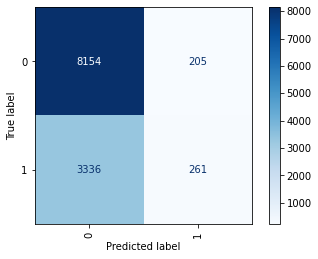

In [67]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(search, X_val, y_val,
                      values_format='.0f', xticks_rotation='vertical', cmap="Blues")

In [36]:
(11127 + 26) / len(y_val)

0.699642431466031

In [ ]:
#what is a persons average rating
#what if I only wanted 5 star books
#it is probably more interesting to do only 5 star books